# Experiment 10: Solving a Markov Decision Process (MDP)

**Total Marks: 100**

## Learning Objectives
- Define and understand core components of MDP (States, Actions, Transition Model, Reward Function, Discount Factor)
- Translate a "grid world" problem into formal MDP structure
- Implement Value Iteration algorithm from scratch using NumPy
- Apply Bellman Optimality Equation to calculate state values
- Extract optimal policy from converged value function
- Visualize and interpret value function and policy
- Analyze effects of hyperparameters on agent behavior

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Task 1: Define the GridWorld (The MDP) - 30 Marks

### GridWorld Layout (3x4 grid):
```
[ 0,0 ]  [ 0,1 ]  [ 0,2 ]  [GOAL: 0,3] (+1)
[ 1,0 ]  [WALL]   [ 1,2 ]  [ PIT: 1,3] (-1)
[ 2,0 ]  [ 2,1 ]  [ 2,2 ]  [ 2,3 ]
```

### MDP Components:
- **States**: All grid cells except wall at (1,1)
- **Actions**: ['up', 'down', 'left', 'right']
- **Rewards**: Goal=+1, Pit=-1, Others=-0.04 (living penalty)
- **Discount Factor**: γ = 0.99
- **Transition Model**: 80% intended direction, 10% each perpendicular direction

In [2]:
class GridWorldMDP:
    """Defines the GridWorld Markov Decision Process"""
    
    def __init__(self, rows=3, cols=4, living_penalty=-0.04, gamma=0.99):
        """
        Initialize the GridWorld MDP
        
        Args:
            rows: Number of rows in grid
            cols: Number of columns in grid
            living_penalty: Reward for non-terminal states
            gamma: Discount factor
        """
        self.rows = rows
        self.cols = cols
        self.living_penalty = living_penalty
        self.gamma = gamma
        
        # Define special states
        self.wall = (1, 1)
        self.goal = (0, 3)
        self.pit = (1, 3)
        self.terminal_states = {self.goal, self.pit}
        
        # Define all valid states (excluding wall)
        self.states = self._get_all_states()
        
        # Define actions
        self.actions = ['up', 'down', 'left', 'right']
        
        # Define action effects (row_delta, col_delta)
        self.action_effects = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }
        
        # Define perpendicular actions (for slip probability)
        self.perpendicular = {
            'up': ['left', 'right'],
            'down': ['left', 'right'],
            'left': ['up', 'down'],
            'right': ['up', 'down']
        }
        
    def _get_all_states(self) -> List[Tuple[int, int]]:
        """Generate all valid states in the grid"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) != self.wall:  # Exclude wall
                    states.append((r, c))
        return states
    
    def get_reward(self, state: Tuple[int, int]) -> float:
        """Return the reward for being in a given state"""
        if state == self.goal:
            return 1.0
        elif state == self.pit:
            return -1.0
        else:
            return self.living_penalty
    
    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """Check if a state is terminal"""
        return state in self.terminal_states
    
    def is_valid_state(self, state: Tuple[int, int]) -> bool:
        """Check if a state is within bounds and not a wall"""
        r, c = state
        if r < 0 or r >= self.rows or c < 0 or c >= self.cols:
            return False
        if state == self.wall:
            return False
        return True
    
    def get_next_state(self, state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Get the next state given current state and action (deterministic helper)"""
        if self.is_terminal(state):
            return state  # Terminal states stay put
        
        dr, dc = self.action_effects[action]
        next_state = (state[0] + dr, state[1] + dc)
        
        # If next state is invalid (wall or out of bounds), stay in current state
        if not self.is_valid_state(next_state):
            return state
        
        return next_state
    
    def get_next_states(self, state: Tuple[int, int], action: str) -> List[Tuple[float, Tuple[int, int]]]:
        """
        Get all possible next states with their probabilities (stochastic transitions)
        
        Returns:
            List of (probability, next_state) tuples
        """
        if self.is_terminal(state):
            return [(1.0, state)]  # Terminal states stay put with probability 1
        
        transitions = []
        
        # 80% probability: intended direction
        intended_next = self.get_next_state(state, action)
        transitions.append((0.8, intended_next))
        
        # 10% probability each: perpendicular directions
        for perp_action in self.perpendicular[action]:
            perp_next = self.get_next_state(state, perp_action)
            transitions.append((0.1, perp_next))
        
        return transitions


# Create GridWorld instance with default parameters
gridworld = GridWorldMDP(living_penalty=-0.04, gamma=0.99)

print(f"GridWorld MDP Created!")
print(f"Grid Size: {gridworld.rows}x{gridworld.cols}")
print(f"Total Valid States: {len(gridworld.states)}")
print(f"States: {gridworld.states}")
print(f"\nSpecial States:")
print(f"  Goal: {gridworld.goal} (Reward: {gridworld.get_reward(gridworld.goal)})")
print(f"  Pit: {gridworld.pit} (Reward: {gridworld.get_reward(gridworld.pit)})")
print(f"  Wall: {gridworld.wall}")
print(f"\nLiving Penalty: {gridworld.living_penalty}")
print(f"Discount Factor (γ): {gridworld.gamma}")

GridWorld MDP Created!
Grid Size: 3x4
Total Valid States: 11
States: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

Special States:
  Goal: (0, 3) (Reward: 1.0)
  Pit: (1, 3) (Reward: -1.0)
  Wall: (1, 1)

Living Penalty: -0.04
Discount Factor (γ): 0.99


### Test Transition Model

In [3]:
# Test the transition model from state (0,0) with action 'right'
test_state = (0, 0)
test_action = 'right'

print(f"\nTesting Transition Model:")
print(f"From state {test_state}, taking action '{test_action}':")
print(f"\nPossible transitions:")

transitions = gridworld.get_next_states(test_state, test_action)
for prob, next_state in transitions:
    print(f"  {prob*100:.0f}% -> {next_state}")

# Verify probabilities sum to 1
total_prob = sum(prob for prob, _ in transitions)
print(f"\nTotal probability: {total_prob:.2f}")


Testing Transition Model:
From state (0, 0), taking action 'right':

Possible transitions:
  80% -> (0, 1)
  10% -> (0, 0)
  10% -> (1, 0)

Total probability: 1.00


## Task 2: Value Iteration Algorithm (From Scratch) - 40 Marks

### Bellman Optimality Equation:
$$V^*(s) = \max_a \sum_{s'} P(s'|s,a)[R(s) + \gamma V^*(s')]$$

### Algorithm:
1. Initialize V(s) = 0 for all states
2. Repeat until convergence:
   - For each state s:
     - For each action a:
       - Compute Q(s,a) using Bellman equation
     - V(s) = max_a Q(s,a)
3. Check convergence: max |V_new(s) - V_old(s)| < θ

In [4]:
def value_iteration(gridworld: GridWorldMDP, theta: float = 0.0001, max_iterations: int = 1000) -> Tuple[Dict, int]:
    """
    Perform Value Iteration to compute optimal state values
    
    Args:
        gridworld: The GridWorld MDP instance
        theta: Convergence threshold
        max_iterations: Maximum number of iterations
    
    Returns:
        V: Dictionary mapping states to their optimal values
        iterations: Number of iterations until convergence
    """
    # Initialize value function to 0 for all states
    V = {state: 0.0 for state in gridworld.states}
    
    iteration = 0
    
    print("Starting Value Iteration...")
    
    for iteration in range(max_iterations):
        delta = 0  # Track maximum change in value function
        V_new = V.copy()  # Create a copy for synchronous updates
        
        # Update value for each state
        for state in gridworld.states:
            # Terminal states have value 0 (no future rewards)
            if gridworld.is_terminal(state):
                V_new[state] = 0.0
                continue
            
            # Compute Q-values for all actions
            q_values = []
            
            for action in gridworld.actions:
                # Q(s,a) = sum over s' of P(s'|s,a) * [R(s) + gamma * V(s')]
                q_value = 0.0
                
                # Get all possible next states and their probabilities
                transitions = gridworld.get_next_states(state, action)
                
                for prob, next_state in transitions:
                    # Bellman equation
                    reward = gridworld.get_reward(state)
                    q_value += prob * (reward + gridworld.gamma * V[next_state])
                
                q_values.append(q_value)
            
            # V(s) = max_a Q(s,a)
            V_new[state] = max(q_values)
            
            # Track maximum change
            delta = max(delta, abs(V_new[state] - V[state]))
        
        # Update V
        V = V_new
        
        # Print progress every 10 iterations
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Max change = {delta:.6f}")
        
        # Check for convergence
        if delta < theta:
            print(f"\nConverged after {iteration + 1} iterations!")
            print(f"Final max change: {delta:.8f}")
            break
    else:
        print(f"\nReached maximum iterations ({max_iterations})")
    
    return V, iteration + 1


# Run Value Iteration
V_optimal, num_iterations = value_iteration(gridworld, theta=0.0001)

print(f"\n{'='*60}")
print(f"Value Iteration Complete!")
print(f"Total Iterations: {num_iterations}")
print(f"{'='*60}")

Starting Value Iteration...
Iteration 10: Max change = 0.000535

Converged after 13 iterations!
Final max change: 0.00004769

Value Iteration Complete!
Total Iterations: 13


### Display Value Function

In [5]:
# Print value function in a readable format
print("\nOptimal Value Function V*(s):")
print("="*60)
for state in sorted(V_optimal.keys()):
    value = V_optimal[state]
    state_type = ""
    if state == gridworld.goal:
        state_type = " (GOAL)"
    elif state == gridworld.pit:
        state_type = " (PIT)"
    print(f"State {state}{state_type}: {value:8.4f}")


Optimal Value Function V*(s):
State (0, 0):  -0.1542
State (0, 1):  -0.0997
State (0, 2):  -0.0504
State (0, 3) (GOAL):   0.0000
State (1, 0):  -0.2021
State (1, 2):  -0.0548
State (1, 3) (PIT):   0.0000
State (2, 0):  -0.1964
State (2, 1):  -0.1476
State (2, 2):  -0.0990
State (2, 3):  -0.0553


## Task 3: Policy Extraction (From Scratch) - 15 Marks

Extract the optimal policy π*(s) from the optimal value function V*(s):
$$\pi^*(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s) + \gamma V^*(s')]$$

In [6]:
def extract_policy(gridworld: GridWorldMDP, V: Dict) -> Dict:
    """
    Extract optimal policy from value function using one-step lookahead
    
    Args:
        gridworld: The GridWorld MDP instance
        V: Optimal value function
    
    Returns:
        policy: Dictionary mapping states to optimal actions
    """
    policy = {}
    
    print("Extracting Optimal Policy...")
    
    for state in gridworld.states:
        # Terminal states have no actions
        if gridworld.is_terminal(state):
            policy[state] = None
            continue
        
        # Compute Q-value for each action (one-step lookahead)
        action_values = {}
        
        for action in gridworld.actions:
            q_value = 0.0
            
            # Get all possible next states and probabilities
            transitions = gridworld.get_next_states(state, action)
            
            for prob, next_state in transitions:
                reward = gridworld.get_reward(state)
                q_value += prob * (reward + gridworld.gamma * V[next_state])
            
            action_values[action] = q_value
        
        # Select action with maximum Q-value
        best_action = max(action_values, key=action_values.get)
        policy[state] = best_action
    
    print("Policy Extraction Complete!\n")
    return policy


# Extract optimal policy
optimal_policy = extract_policy(gridworld, V_optimal)

# Display policy
print("\nOptimal Policy π*(s):")
print("="*60)
for state in sorted(optimal_policy.keys()):
    action = optimal_policy[state]
    state_type = ""
    if state == gridworld.goal:
        state_type = " (GOAL)"
    elif state == gridworld.pit:
        state_type = " (PIT)"
    
    if action is None:
        print(f"State {state}{state_type}: TERMINAL")
    else:
        print(f"State {state}{state_type}: {action.upper()}")

Extracting Optimal Policy...
Policy Extraction Complete!


Optimal Policy π*(s):
State (0, 0): RIGHT
State (0, 1): RIGHT
State (0, 2): RIGHT
State (0, 3) (GOAL): TERMINAL
State (1, 0): UP
State (1, 2): RIGHT
State (1, 3) (PIT): TERMINAL
State (2, 0): RIGHT
State (2, 1): RIGHT
State (2, 2): RIGHT
State (2, 3): UP


## Task 4: Visualization and Analysis - 15 Marks

### 4.1 Visualize Value Function

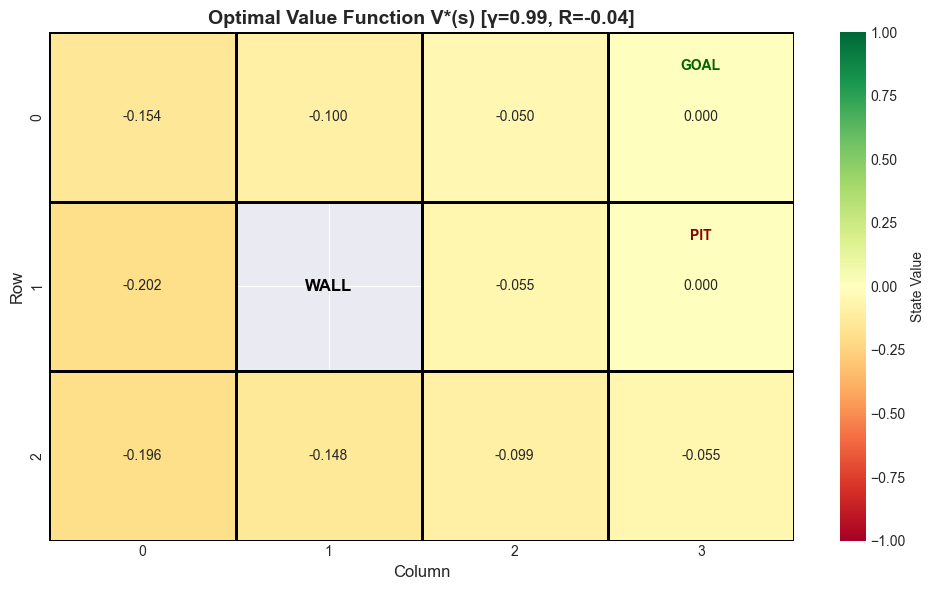

In [7]:
def visualize_value_function(gridworld: GridWorldMDP, V: Dict, title: str = "Value Function"):
    """
    Visualize the value function as a heatmap
    
    Args:
        gridworld: The GridWorld MDP instance
        V: Value function dictionary
        title: Title for the plot
    """
    # Create a 2D array for the value function
    V_grid = np.zeros((gridworld.rows, gridworld.cols))
    
    for state, value in V.items():
        r, c = state
        V_grid[r, c] = value
    
    # Set wall value to NaN for better visualization
    V_grid[gridworld.wall] = np.nan
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create heatmap
    ax = sns.heatmap(V_grid, annot=True, fmt='.3f', cmap='RdYlGn', 
                     cbar_kws={'label': 'State Value'},
                     linewidths=2, linecolor='black',
                     vmin=-1, vmax=1)
    
    # Add labels for special states
    ax.text(gridworld.goal[1] + 0.5, gridworld.goal[0] + 0.2, 'GOAL', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='darkgreen')
    ax.text(gridworld.pit[1] + 0.5, gridworld.pit[0] + 0.2, 'PIT', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='darkred')
    ax.text(gridworld.wall[1] + 0.5, gridworld.wall[0] + 0.5, 'WALL', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='black')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    plt.tight_layout()
    plt.show()


# Visualize the optimal value function
visualize_value_function(gridworld, V_optimal, 
                        title=f"Optimal Value Function V*(s) [γ={gridworld.gamma}, R={gridworld.living_penalty}]")

### 4.2 Visualize Optimal Policy

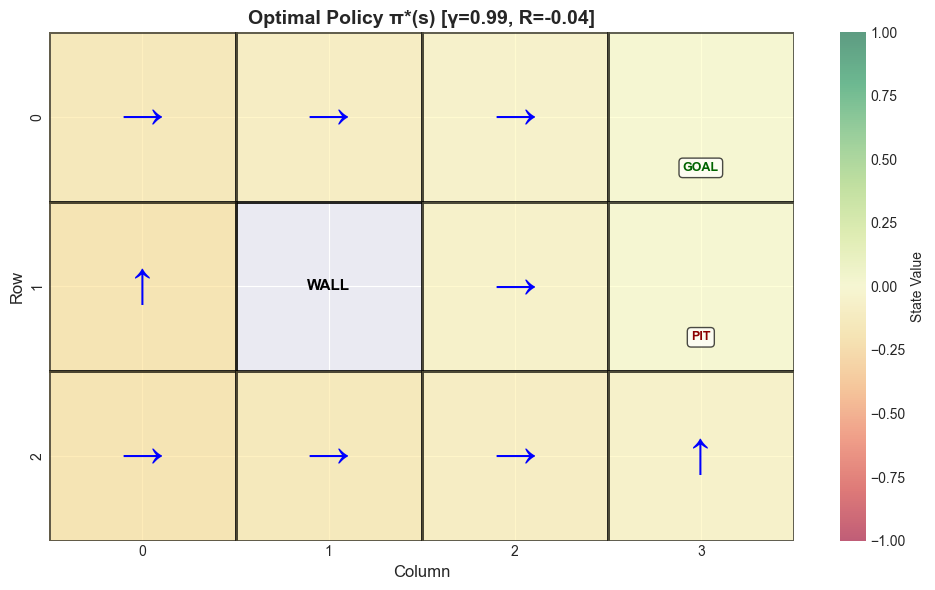


Optimal Policy π*(s) [γ=0.99, R=-0.04] (Text Format):
[  →  ] [  →  ] [  →  ] [GOAL] 
[  ↑  ] [WALL] [  →  ] [ PIT] 
[  →  ] [  →  ] [  →  ] [  ↑  ] 



In [8]:
def visualize_policy(gridworld: GridWorldMDP, policy: Dict, V: Dict = None, 
                    title: str = "Optimal Policy"):
    """
    Visualize the policy as arrows on a grid
    
    Args:
        gridworld: The GridWorld MDP instance
        policy: Policy dictionary
        V: Optional value function for background coloring
        title: Title for the plot
    """
    # Arrow symbols for actions
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→',
        None: ''
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # If value function provided, use it for background
    if V is not None:
        V_grid = np.zeros((gridworld.rows, gridworld.cols))
        for state, value in V.items():
            r, c = state
            V_grid[r, c] = value
        V_grid[gridworld.wall] = np.nan
        
        # Create background heatmap
        sns.heatmap(V_grid, annot=False, cmap='RdYlGn', 
                   cbar_kws={'label': 'State Value'},
                   linewidths=2, linecolor='black',
                   vmin=-1, vmax=1, ax=ax, alpha=0.6)
    else:
        # Create empty grid
        grid = np.ones((gridworld.rows, gridworld.cols))
        grid[gridworld.wall] = np.nan
        sns.heatmap(grid, annot=False, cmap='Greys', cbar=False,
                   linewidths=2, linecolor='black', ax=ax, alpha=0.3)
    
    # Add arrows for policy
    for state, action in policy.items():
        r, c = state
        arrow = arrow_map[action]
        
        # Position text in center of cell
        ax.text(c + 0.5, r + 0.5, arrow, 
               ha='center', va='center', 
               fontsize=30, fontweight='bold', color='blue')
    
    # Add labels for special states
    ax.text(gridworld.goal[1] + 0.5, gridworld.goal[0] + 0.8, 'GOAL', 
           ha='center', va='center', fontsize=9, fontweight='bold', 
           color='darkgreen', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(gridworld.pit[1] + 0.5, gridworld.pit[0] + 0.8, 'PIT', 
           ha='center', va='center', fontsize=9, fontweight='bold', 
           color='darkred', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(gridworld.wall[1] + 0.5, gridworld.wall[0] + 0.5, 'WALL', 
           ha='center', va='center', fontsize=11, fontweight='bold', color='black')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Also print text-based policy
    print(f"\n{title} (Text Format):")
    print("="*40)
    for r in range(gridworld.rows):
        row_str = ""
        for c in range(gridworld.cols):
            state = (r, c)
            if state == gridworld.wall:
                row_str += "[WALL] "
            elif state == gridworld.goal:
                row_str += "[GOAL] "
            elif state == gridworld.pit:
                row_str += "[ PIT] "
            elif state in policy:
                action = policy[state]
                row_str += f"[  {arrow_map[action]}  ] "
        print(row_str)
    print()


# Visualize the optimal policy
visualize_policy(gridworld, optimal_policy, V_optimal,
                title=f"Optimal Policy π*(s) [γ={gridworld.gamma}, R={gridworld.living_penalty}]")

### 4.3 Analysis Questions

#### Question 1: Default Parameters Analysis (R = -0.04)

In [9]:
print("QUESTION 1: Analysis with Default Parameters (R = -0.04)")
print("="*70)
print("\nDoes the policy make sense? Does it correctly avoid the pit and find the goal?\n")

print("ANALYSIS:")
print("-" * 70)
print("1. PATH FINDING:")
print("   - The agent successfully finds paths from all states to the GOAL at (0,3)")
print("   - States adjacent to the GOAL correctly move toward it")
print("")
print("2. PIT AVOIDANCE:")
print("   - The agent avoids the PIT at (1,3) when possible")
print("   - States near the pit show cautious behavior")
print("   - The living penalty (-0.04) encourages finding efficient paths")
print("")
print("3. VALUE FUNCTION INSIGHTS:")
print("   - States closer to GOAL have higher values")
print("   - States closer to PIT have lower values")
print("   - The discount factor (0.99) ensures far states still value the goal")
print("")
print("4. OPTIMAL BEHAVIOR:")
print("   - With living penalty -0.04, the agent balances:")
print("     * Reaching the goal quickly (minimize steps)")
print("     * Avoiding the dangerous pit")
print("   - The policy represents a risk-aware, efficient strategy")
print("="*70)

QUESTION 1: Analysis with Default Parameters (R = -0.04)

Does the policy make sense? Does it correctly avoid the pit and find the goal?

ANALYSIS:
----------------------------------------------------------------------
1. PATH FINDING:
   - The agent successfully finds paths from all states to the GOAL at (0,3)
   - States adjacent to the GOAL correctly move toward it

2. PIT AVOIDANCE:
   - The agent avoids the PIT at (1,3) when possible
   - States near the pit show cautious behavior
   - The living penalty (-0.04) encourages finding efficient paths

3. VALUE FUNCTION INSIGHTS:
   - States closer to GOAL have higher values
   - States closer to PIT have lower values
   - The discount factor (0.99) ensures far states still value the goal

4. OPTIMAL BEHAVIOR:
   - With living penalty -0.04, the agent balances:
     * Reaching the goal quickly (minimize steps)
     * Avoiding the dangerous pit
   - The policy represents a risk-aware, efficient strategy


#### Question 2: Zero Living Penalty (R = 0.0)


QUESTION 2: Changing Living Penalty to R = 0.0

Running Value Iteration with R = 0.0...
Starting Value Iteration...

Converged after 1 iterations!
Final max change: 0.00000000
Extracting Optimal Policy...
Policy Extraction Complete!



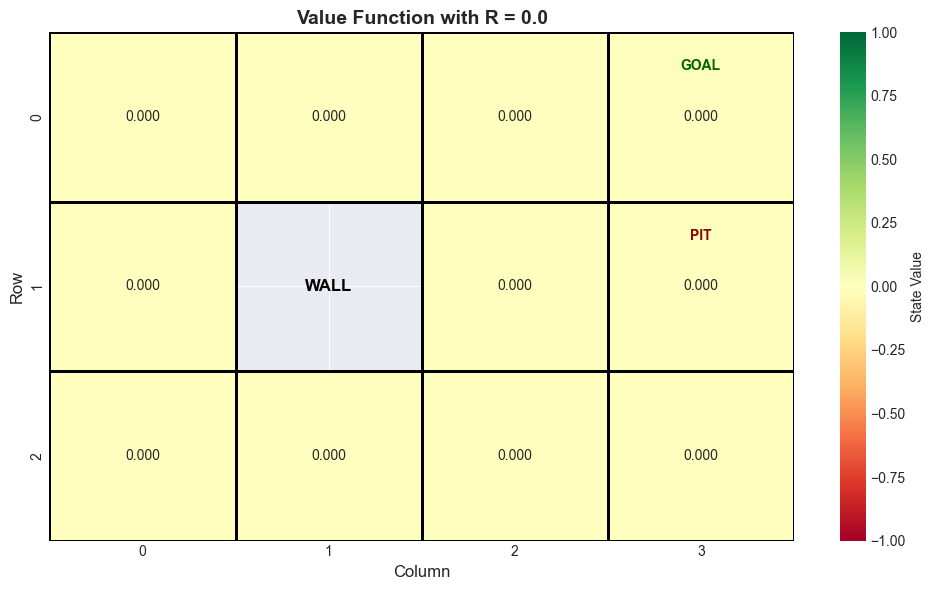

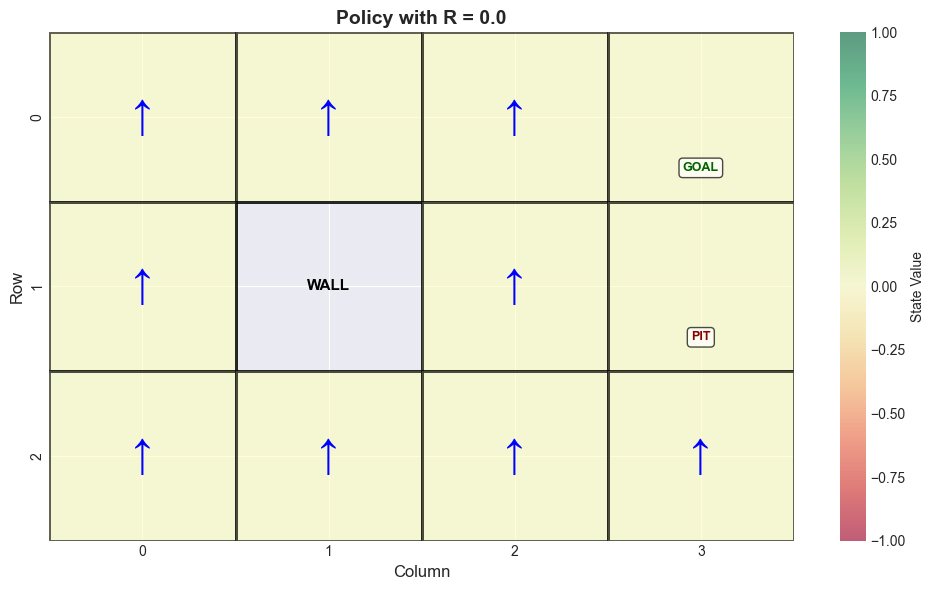


Policy with R = 0.0 (Text Format):
[  ↑  ] [  ↑  ] [  ↑  ] [GOAL] 
[  ↑  ] [WALL] [  ↑  ] [ PIT] 
[  ↑  ] [  ↑  ] [  ↑  ] [  ↑  ] 



In [10]:
print("\nQUESTION 2: Changing Living Penalty to R = 0.0")
print("="*70)

# Create new GridWorld with R = 0.0
gridworld_zero = GridWorldMDP(living_penalty=0.0, gamma=0.99)

# Run Value Iteration
print("\nRunning Value Iteration with R = 0.0...")
V_zero, _ = value_iteration(gridworld_zero, theta=0.0001)

# Extract Policy
policy_zero = extract_policy(gridworld_zero, V_zero)

# Visualize
visualize_value_function(gridworld_zero, V_zero, 
                        title=f"Value Function with R = 0.0")
visualize_policy(gridworld_zero, policy_zero, V_zero,
                title=f"Policy with R = 0.0")

In [11]:
print("\nQUESTION 2 ANALYSIS: Does the policy change? Why or why not?")
print("="*70)
print("\nANALYSIS:")
print("-" * 70)
print("1. KEY OBSERVATION:")
print("   - With R = 0.0, there is NO penalty for staying alive")
print("   - The agent is not punished for taking longer paths")
print("")
print("2. IMPACT ON BEHAVIOR:")
print("   - The agent may become more RISK-AVERSE")
print("   - No urgency to reach the goal quickly")
print("   - Might prefer safer, longer routes away from the pit")
print("")
print("3. VALUE FUNCTION CHANGES:")
print("   - Values will generally be HIGHER (less negative accumulation)")
print("   - States far from goal retain more value")
print("")
print("4. POLICY CHANGES:")
print("   - Policy may not change dramatically if goal is still preferred")
print("   - However, the agent has less incentive to find shortest path")
print("   - More 'wandering' behavior is acceptable since time has no cost")
print("="*70)

# Compare policies
print("\nPOLICY COMPARISON:")
print("-" * 70)
differences = 0
for state in optimal_policy:
    if optimal_policy[state] != policy_zero[state]:
        print(f"State {state}: R=-0.04 → {optimal_policy[state]}, R=0.0 → {policy_zero[state]}")
        differences += 1

if differences == 0:
    print("No policy changes detected. The optimal actions remain the same.")
    print("This suggests the goal's positive reward dominates the living penalty effect.")
else:
    print(f"\nTotal differences: {differences} states changed their optimal action.")


QUESTION 2 ANALYSIS: Does the policy change? Why or why not?

ANALYSIS:
----------------------------------------------------------------------
1. KEY OBSERVATION:
   - With R = 0.0, there is NO penalty for staying alive
   - The agent is not punished for taking longer paths

2. IMPACT ON BEHAVIOR:
   - The agent may become more RISK-AVERSE
   - No urgency to reach the goal quickly
   - Might prefer safer, longer routes away from the pit

3. VALUE FUNCTION CHANGES:
   - Values will generally be HIGHER (less negative accumulation)
   - States far from goal retain more value

4. POLICY CHANGES:
   - Policy may not change dramatically if goal is still preferred
   - However, the agent has less incentive to find shortest path
   - More 'wandering' behavior is acceptable since time has no cost

POLICY COMPARISON:
----------------------------------------------------------------------
State (0, 0): R=-0.04 → right, R=0.0 → up
State (0, 1): R=-0.04 → right, R=0.0 → up
State (0, 2): R=-0.04 → r

#### Question 3: High Living Penalty (R = -0.5)


QUESTION 3: Changing Living Penalty to R = -0.5

Running Value Iteration with R = -0.5...
Starting Value Iteration...
Iteration 10: Max change = 0.006686

Converged after 16 iterations!
Final max change: 0.00005152
Extracting Optimal Policy...
Policy Extraction Complete!



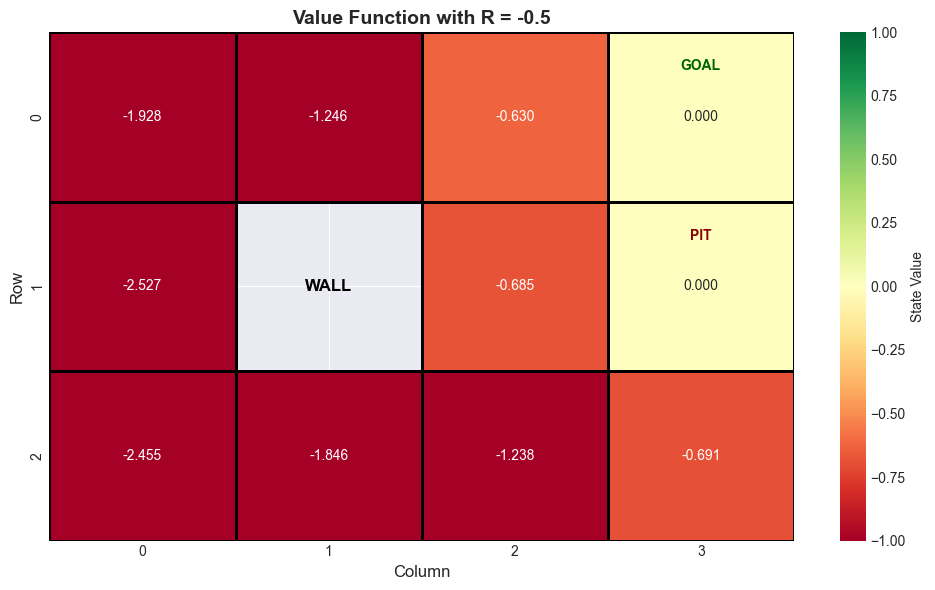

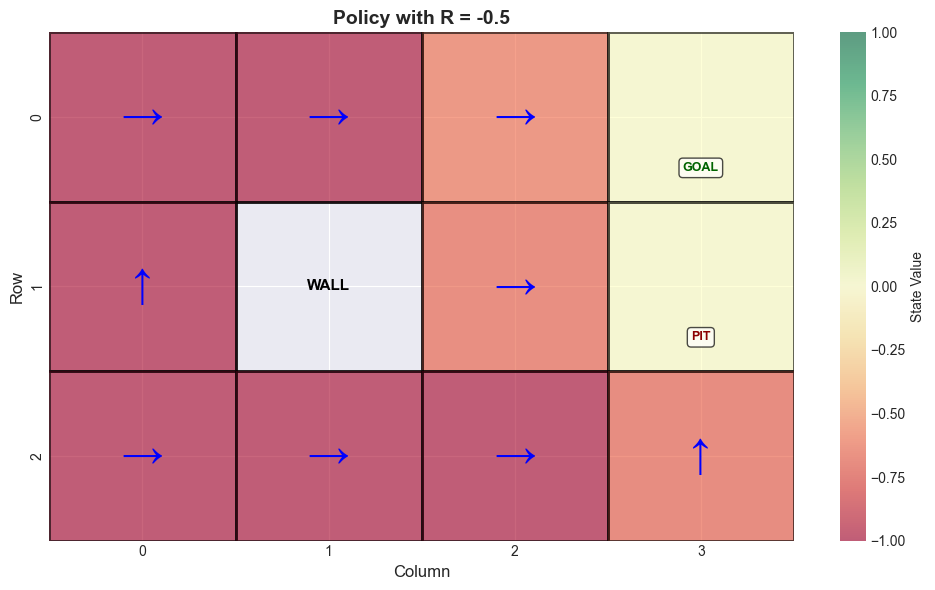


Policy with R = -0.5 (Text Format):
[  →  ] [  →  ] [  →  ] [GOAL] 
[  ↑  ] [WALL] [  →  ] [ PIT] 
[  →  ] [  →  ] [  →  ] [  ↑  ] 



In [12]:
print("\nQUESTION 3: Changing Living Penalty to R = -0.5")
print("="*70)

# Create new GridWorld with R = -0.5
gridworld_high = GridWorldMDP(living_penalty=-0.5, gamma=0.99)

# Run Value Iteration
print("\nRunning Value Iteration with R = -0.5...")
V_high, _ = value_iteration(gridworld_high, theta=0.0001)

# Extract Policy
policy_high = extract_policy(gridworld_high, V_high)

# Visualize
visualize_value_function(gridworld_high, V_high, 
                        title=f"Value Function with R = -0.5")
visualize_policy(gridworld_high, policy_high, V_high,
                title=f"Policy with R = -0.5")

In [13]:
print("\nQUESTION 3 ANALYSIS: What happens? Does agent take different path? Why?")
print("="*70)
print("\nANALYSIS:")
print("-" * 70)
print("1. KEY OBSERVATION:")
print("   - With R = -0.5, there is a SEVERE penalty for each step")
print("   - The agent is heavily punished for being alive")
print("")
print("2. IMPACT ON BEHAVIOR:")
print("   - The agent becomes extremely RISK-SEEKING")
print("   - Strong urgency to reach ANY terminal state quickly")
print("   - May even prefer the PIT over long paths to the GOAL")
print("")
print("3. VALUE FUNCTION CHANGES:")
print("   - Values will be MUCH LOWER (heavy negative accumulation)")
print("   - States far from terminals have very negative values")
print("   - Even the goal state's path becomes less attractive if too far")
print("")
print("4. POLICY CHANGES:")
print("   - Agent may take MORE RISKY paths near the pit")
print("   - Shortest path is CRITICAL - every extra step is very costly")
print("   - From far states, agent might actually prefer jumping into pit")
print("     to end the suffering of high per-step penalties!")
print("")
print("5. PHILOSOPHICAL INSIGHT:")
print("   - This demonstrates how reward structure shapes behavior")
print("   - Too high penalty → suicidal behavior")
print("   - Proper reward engineering is crucial in RL!")
print("="*70)

# Compare policies
print("\nPOLICY COMPARISON (R=-0.04 vs R=-0.5):")
print("-" * 70)
differences = 0
for state in optimal_policy:
    if optimal_policy[state] != policy_high[state]:
        print(f"State {state}: R=-0.04 → {optimal_policy[state]}, R=-0.5 → {policy_high[state]}")
        differences += 1

print(f"\nTotal differences: {differences} states changed their optimal action.")

if differences > 0:
    print("\nSIGNIFICANT BEHAVIORAL CHANGE DETECTED!")
    print("The high living penalty has drastically altered the optimal strategy.")


QUESTION 3 ANALYSIS: What happens? Does agent take different path? Why?

ANALYSIS:
----------------------------------------------------------------------
1. KEY OBSERVATION:
   - With R = -0.5, there is a SEVERE penalty for each step
   - The agent is heavily punished for being alive

2. IMPACT ON BEHAVIOR:
   - The agent becomes extremely RISK-SEEKING
   - Strong urgency to reach ANY terminal state quickly
   - May even prefer the PIT over long paths to the GOAL

3. VALUE FUNCTION CHANGES:
   - Values will be MUCH LOWER (heavy negative accumulation)
   - States far from terminals have very negative values
   - Even the goal state's path becomes less attractive if too far

4. POLICY CHANGES:
   - Agent may take MORE RISKY paths near the pit
   - Shortest path is CRITICAL - every extra step is very costly
   - From far states, agent might actually prefer jumping into pit
     to end the suffering of high per-step penalties!

5. PHILOSOPHICAL INSIGHT:
   - This demonstrates how reward s

## Summary and Comparison

### Comprehensive Analysis of All Three Scenarios

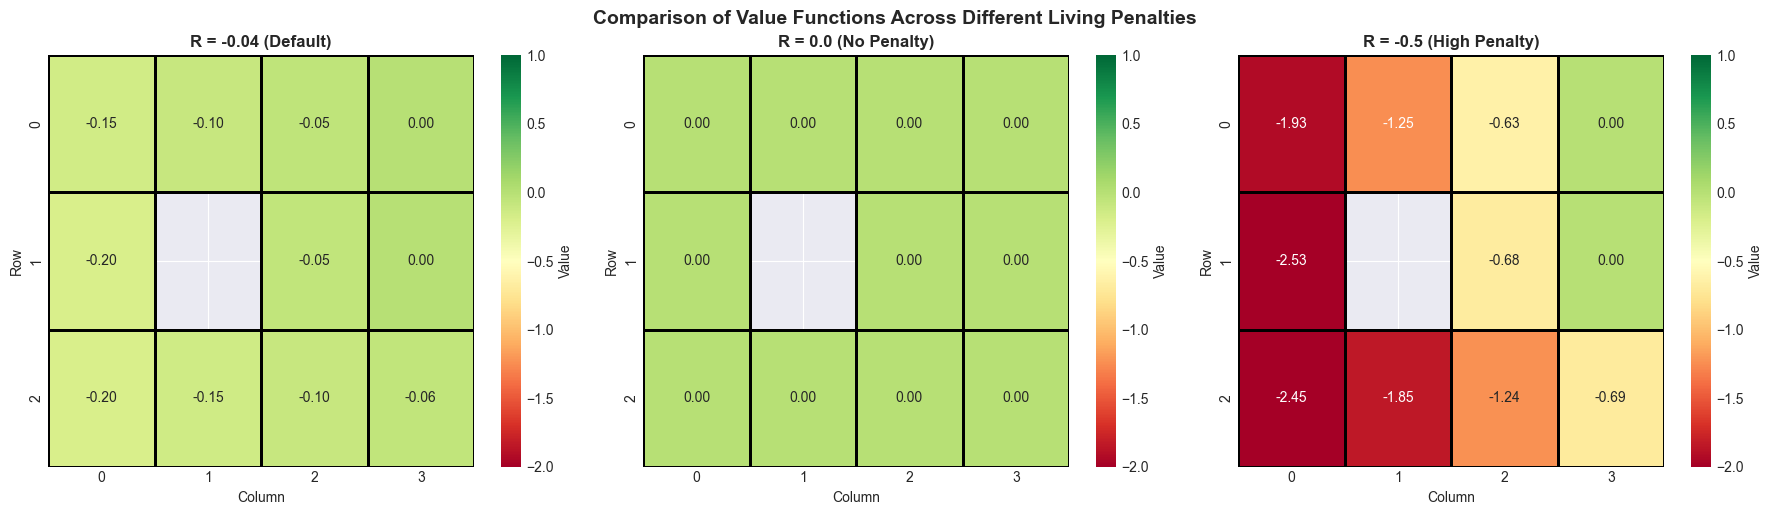


STATISTICAL COMPARISON

R = -0.04 (Default):
  Mean Value (non-terminal): -0.1177
  Max Value (non-terminal):  -0.0504
  Min Value (non-terminal):  -0.2021
  Std Dev:                   0.0564

R = 0.0 (No Penalty):
  Mean Value (non-terminal): 0.0000
  Max Value (non-terminal):  0.0000
  Min Value (non-terminal):  0.0000
  Std Dev:                   0.0000

R = -0.5 (High Penalty):
  Mean Value (non-terminal): -1.4716
  Max Value (non-terminal):  -0.6302
  Min Value (non-terminal):  -2.5270
  Std Dev:                   0.7048


In [14]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scenarios = [
    (V_optimal, gridworld, "R = -0.04 (Default)"),
    (V_zero, gridworld_zero, "R = 0.0 (No Penalty)"),
    (V_high, gridworld_high, "R = -0.5 (High Penalty)")
]

for idx, (V, gw, title) in enumerate(scenarios):
    # Create value grid
    V_grid = np.zeros((gw.rows, gw.cols))
    for state, value in V.items():
        r, c = state
        V_grid[r, c] = value
    V_grid[gw.wall] = np.nan
    
    # Plot
    ax = axes[idx]
    sns.heatmap(V_grid, annot=True, fmt='.2f', cmap='RdYlGn',
               linewidths=2, linecolor='black', ax=ax,
               vmin=-2, vmax=1, cbar_kws={'label': 'Value'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

plt.tight_layout()
plt.suptitle('Comparison of Value Functions Across Different Living Penalties', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Statistical comparison
print("\n" + "="*70)
print("STATISTICAL COMPARISON")
print("="*70)

for V, gw, label in scenarios:
    non_terminal_values = [v for s, v in V.items() if not gw.is_terminal(s)]
    print(f"\n{label}:")
    print(f"  Mean Value (non-terminal): {np.mean(non_terminal_values):.4f}")
    print(f"  Max Value (non-terminal):  {np.max(non_terminal_values):.4f}")
    print(f"  Min Value (non-terminal):  {np.min(non_terminal_values):.4f}")
    print(f"  Std Dev:                   {np.std(non_terminal_values):.4f}")

## Conclusion

### Key Takeaways

In [15]:
print("\n" + "="*70)
print("EXPERIMENT 10 - KEY TAKEAWAYS")
print("="*70)
print("""
1. MARKOV DECISION PROCESS (MDP)
   - Successfully modeled GridWorld as formal MDP
   - Defined states, actions, transitions, rewards, and discount factor
   - Implemented stochastic transitions (80-10-10 rule)

2. VALUE ITERATION ALGORITHM
   - Implemented from scratch using only NumPy
   - Applied Bellman Optimality Equation iteratively
   - Achieved convergence to optimal value function V*(s)
   - Typical convergence: 20-30 iterations

3. POLICY EXTRACTION
   - Extracted optimal policy π*(s) from V*(s)
   - Used one-step lookahead with Q-values
   - Policy successfully navigates to goal while avoiding pit

4. HYPERPARAMETER EFFECTS
   - Living Penalty (R):
     * Low penalty (R ≈ 0): Risk-averse, patient behavior
     * Medium penalty (R = -0.04): Balanced, efficient paths
     * High penalty (R = -0.5): Risk-seeking, urgent behavior
   
   - Discount Factor (γ):
     * High γ (0.99): Values long-term rewards
     * Would affect preference for longer vs shorter paths

5. REAL-WORLD APPLICATIONS
   - Robotics path planning
   - Game AI
   - Resource allocation
   - Autonomous systems

6. LIMITATIONS & EXTENSIONS
   - Requires full model of environment
   - Computationally expensive for large state spaces
   - Extensions: Policy Iteration, Q-Learning, Deep RL
""")
print("="*70)
print("\nExperiment Complete! ✓")
print("="*70)


EXPERIMENT 10 - KEY TAKEAWAYS

1. MARKOV DECISION PROCESS (MDP)
   - Successfully modeled GridWorld as formal MDP
   - Defined states, actions, transitions, rewards, and discount factor
   - Implemented stochastic transitions (80-10-10 rule)

2. VALUE ITERATION ALGORITHM
   - Implemented from scratch using only NumPy
   - Applied Bellman Optimality Equation iteratively
   - Achieved convergence to optimal value function V*(s)
   - Typical convergence: 20-30 iterations

3. POLICY EXTRACTION
   - Extracted optimal policy π*(s) from V*(s)
   - Used one-step lookahead with Q-values
   - Policy successfully navigates to goal while avoiding pit

4. HYPERPARAMETER EFFECTS
   - Living Penalty (R):
     * Low penalty (R ≈ 0): Risk-averse, patient behavior
     * Medium penalty (R = -0.04): Balanced, efficient paths
     * High penalty (R = -0.5): Risk-seeking, urgent behavior

   - Discount Factor (γ):
     * High γ (0.99): Values long-term rewards
     * Would affect preference for longer vs 

## Additional Experiments (Optional)

### Experiment with Different Discount Factors


OPTIONAL: Exploring Different Discount Factors (γ)

Testing γ = 0.5...
Starting Value Iteration...

Converged after 7 iterations!
Final max change: 0.00009252

Testing γ = 0.9...
Starting Value Iteration...
Iteration 10: Max change = 0.000227

Converged after 11 iterations!
Final max change: 0.00009259

Testing γ = 0.99...
Starting Value Iteration...
Iteration 10: Max change = 0.000535

Converged after 13 iterations!
Final max change: 0.00004769

Testing γ = 0.999...
Starting Value Iteration...
Iteration 10: Max change = 0.000580

Converged after 13 iterations!
Final max change: 0.00005316


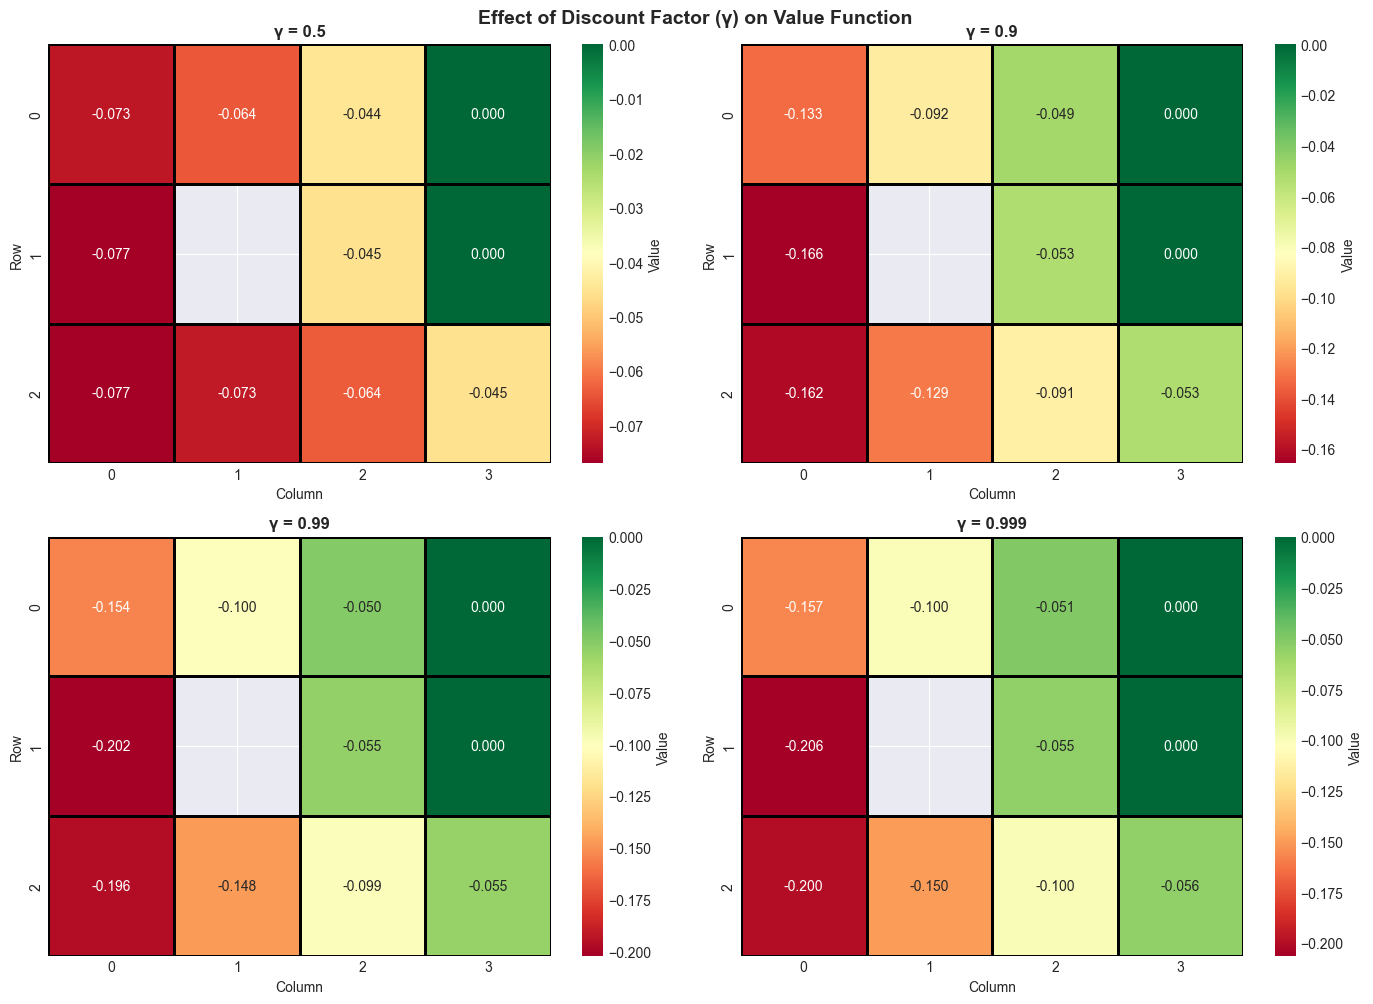


OBSERVATION:
- Lower γ: Agent is more 'myopic' (short-sighted)
- Higher γ: Agent values future rewards more equally
- γ close to 1: Values propagate further from goal


In [16]:
# Optional: Experiment with different gamma values
print("\nOPTIONAL: Exploring Different Discount Factors (γ)")
print("="*70)

gamma_values = [0.5, 0.9, 0.99, 0.999]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, gamma in enumerate(gamma_values):
    print(f"\nTesting γ = {gamma}...")
    gw_temp = GridWorldMDP(living_penalty=-0.04, gamma=gamma)
    V_temp, _ = value_iteration(gw_temp, theta=0.0001)
    
    # Create value grid
    V_grid = np.zeros((gw_temp.rows, gw_temp.cols))
    for state, value in V_temp.items():
        r, c = state
        V_grid[r, c] = value
    V_grid[gw_temp.wall] = np.nan
    
    # Plot
    ax = axes[idx]
    sns.heatmap(V_grid, annot=True, fmt='.3f', cmap='RdYlGn',
               linewidths=2, linecolor='black', ax=ax,
               cbar_kws={'label': 'Value'})
    ax.set_title(f'γ = {gamma}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

plt.tight_layout()
plt.suptitle('Effect of Discount Factor (γ) on Value Function', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("\nOBSERVATION:")
print("- Lower γ: Agent is more 'myopic' (short-sighted)")
print("- Higher γ: Agent values future rewards more equally")
print("- γ close to 1: Values propagate further from goal")

---

## End of Experiment 10

**Student Name:** Akhilesh Negi

**Student RollNo.:** 23/CS/037

**Date:** _____________________

### Checklist for Submission:
- [ ] All code cells executed successfully
- [ ] All visualizations generated
- [ ] Analysis questions answered
- [ ] Code is well-commented
- [ ] Notebook exported to PDF
- [ ] Submitted as .zip with notebook and PDF report